# Variational Autoencoder (VAE) with the Keras Functional API

Variational autoencoders, which are generative, can be used to manipulate datasets by learning the distribution of this input data. Here, Keras deep learning framework will be used to create a convolutional variational autoencoder, which will then be trained on the MNIST dataset. The latent space can then be visualised, in addition to new samples being generated from the latent space.

This has been adapted from the Bayesian course within the Advanced Machine Learning Specialisation on Coursera.

In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Variational Autoencoder

Variational Autoencoders are probabilistic models of data based on a continious mixture of distributions. They learn to encode multivariate probability distributions into latent space, given their configuration usually Gaussian ones. Sampling fro mthe distribution gives a point in latent space that, given the distribution, is oriented around some mean value and standard deviation. Combining this with a Kullback-Leibler divergence segment in the loss function leads to a latent space that is both continuous and complete: for every point sampled close to the distribution’s mean and standard deviation the output should be both similar to samples around that sample and should make sense.

Besides the regular things one can do with an autoencoder (like denoising and dimensionality reduction), the principles of a VAE allow their use for generative purposes.

Here, Keras deep learning framework will be used for creating a VAE. It consists of three individual parts: the encoder, the decoder and the VAE as a whole. The Keras Functional API allows the combination of layers easily.

The MNIST dataset will be used for training the autoencoder. This dataset contains thousands of 28 x 28 pixel images of handwritten digits. As such, this autoencoder will learn the distribution of handwritten digits across (two)dimensional latent space, which can then be used to manipulate samples into a format desired.

### Load the MNIST data

In [2]:
#load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

### Model configuration

Set configuration parameters for data and model.

The width and height of configuration settings is determined by training data. Here, they will be img_width = img_height = 28, as the MNIST dataset contains samples that are 28 x 28 pixels.

Batch size is set to 128 samples per (mini)batch (quite normal). The same is true for the number of epochs, which was set to 100. 20% of the training data is used for validation purposes (also quite normal).

Latent space will be two-dimensional – which means that a significant information bottleneck will be created which should yield good results with autoencoders on relatively simple datasets. 

The num_channels parameter can be configured to equal the number of image channels: for RGB data, this is 3 (red – green – blue), and for grayscale data (such as MNIST), this is 1.

In [3]:
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

### Data preprocessing

This will involve the following:
+ reshape the data so that it takes the shape (X, 28, 28, 1), where X is the number of samples in either the training or testing dataset, and set (28, 28, 1) as input_shape.
+ parse the numbers as floats, which should speed up the training process 
+ normalise the data, which is favourable for the neural network

In [4]:
#reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

In [5]:
#parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

In [6]:
#normalise data
input_train = input_train / 255
input_test = input_test / 255

### Create the encoder

This involves 3 steps:
+ Define the encoder
+ Perform the reparameterisation trick in order to allow the linking of the encoder to the decoder later, to instantiate the VAE as a whole. 
+ Instantiate the encoder

#### Defining the encoder

This will involve as follows:
+ The Input layer accepts data with input_shape = (28, 28, 1)
+ Two-dimensional convolutional layer, or Conv2D, which learns 8 filters by deploying a 3x3 kernel which it convolves over the input. It has a stride of two, which means that it skips over the input during the convolution as well, speeding up the learning process. It employs ‘same’ padding and ReLU activation (officially, it is best to use He init with ReLU activating layers, but since the dataset is relatively small, it should not be too much of a problem).
+ The Batch Normalisation layer ensures that the outputs of the Conv2D layer that are input to the next Conv2D layer have a steady mean and variance, likely 𝜇=0.0,𝜎=1.0 (plus some 𝜖, an error term to ensure numerical stability). This benefits the learning process.
+ Another Conv2D layer, which learns 16 filters and for the rest is equal to the first Conv2D layer.
+ Batch Normalisation once again.
+ A Flatten layer, which only serves to flatten the multidimensional data from the convolutional layers into a one-dimensional shape. This must be done as the densely-connected layers that are used next require data to have this shape.
+ A Dense layer with 20 output neurons. This is the autoencoder bottleneck.
+ Batch Normalisation once again.
+ The final two layers, mu and sigma, are not separate from each other. The first outputs the mean values 𝜇 of the encoded input and the second outputs the stddevs 𝜎. With these, the random variables that constitute the point in latent space onto which some input is mapped can be sampled.

In [7]:
#definition
i = Input(shape=input_shape, name='encoder_input')
cx = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(20, activation='relu')(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

#### Retrieve the shape of the final Conv2D output

This is needed when defining the layers of the decoder.

In [8]:
#get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

#### Reparameterisation trick

If neural networks are being used (or, to be more precise, gradient descent) for optimising the variational autoencoder, some expected loss value is being minimised, which can be estimated with Monte-Carlo techniques (Huang, n.d.). However, this requires that the loss function is differentiable, which is not necessarily the case, as it is dependent on the parameter of some probability distribution that is not known about. In this case, it is possible to rewrite the equation, but then it no longer has the form of an expectation, making it impossible to use the Monte-Carlo techniques usable before.

However, if the sample fed to the function can be reparameterised into the shape 𝜇+𝜎2×𝜖, it now becomes possible to use gradient descent for estimating the gradients accurately (Gunderson, n.d.; Huang, n.d.).

This is what the following code does; it “samples” the value for 𝑧 from the computed 𝜇 and 𝜎 values by resampling into mu + K.exp(sigma / 2) * eps.

This is then used with a Lambda to ensure that correct gradients are computed during the backwards pass based on the values for mu and sigma.

In [10]:
#define sampling with reparameterisation trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [11]:
#use reparameterisation trick to ensure correct gradient
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

#### Encoder instantiation

This takes inputs through input layer i, and outputs the values generated by the mu, sigma and z layers (i.e., the individual means and standard deviations, and the point sampled from the random variable represented by them).

In [12]:
#instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Creating the decoder

This involves two steps: 
+ define layers of decoder
+ instantiating the decoder

####  Defining the decoder

This involves as follows:
+ An Input layer, the decoder_input layer, which takes input with the shape (latent_dim, ); this is the vector sampled for z with the encoder.
+ To upsample the point in latent space with Conv2DTranspose layers, in exactly the opposite symmetrical order as downsampled with the encoder, the data must first be brought back from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last convolutional layer of the encoder. This is why the conv_shape variable was needed. Now a Dense layer is added, which has conv_shape[1] * conv_shape[2] * conv_shape[3] output, and converts the latent space into many outputs.
+ A Reshape layer to convert the output of the Dense layer into the output shape of the last convolutional layer: (conv_shape[1], conv_shape[2], conv_shape[3] = (7, 7, 16). 16 filters learnt with 7x7 pixels per filter.
+ Conv2DTranspose and Batch Normalisation is then used in the exact opposite order as with the encoder to upsample the data into 28x28 pixels (which is equal to the width and height of the inputs). However, there are still 8 filters, so the shape so far is (28, 28, 8).
+ A final Conv2DTranspose layer which does nothing to the width and height of the data, but ensures that the number of filters learns equals num_channels. For MNIST data, where num_channels = 1, this means that the shape of the output will be (28, 28, 1). This last layer also uses Sigmoid activation, which allows the use of binary crossentropy loss when computing the reconstruction loss part of the loss function.

In [13]:
#definition
d_i = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x = BatchNormalization()(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx = BatchNormalization()(cx)
o = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

#### Decoder instantiation

In [14]:
#instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_4 (Batch (None, 784)               3136      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 8)         1160

### Creating the VAE as a whole

The outputs of the entire VAE are the original inputs, encoded by the encoder, and decoded by the decoder.

That is how vae_outputs = decoder(encoder(i)[2]) is arrived at: inputs i are encoded by the encoder into [mu, sigma, z] (individual means and standard deviations with the sampled z as well). The sampled z values (hence the [2]) are then taken and fed it to the decoder, which ensures that the correct VAE output is arrived at.

The model is instantiated: i are the inputs, and vae_outputs are the outputs.

In [15]:
#instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


### Defining custom VAE loss function

Usually, with neural networks, model configuration is done with model.compile, where a loss function is specified such as binary crossentropy. However, when looking at how VAEs are optimised, it is not a simple loss function that is used: reconstruction loss is used (in this case, binary crossentropy loss) together with KL divergence loss to ensure that the latent space is both continuous and complete.

Reconstruction_loss is the binary crossentropy value computed for the flattened true values (representing the targets, i.e. ground truth) and the pred prediction values generated by the VAE. It is multiplied with img_width and img_height to reduce the impact of flattening.

KL divergence loss can be rewritten in the formula defined in the function (Wiseodd, 2016).

50% reconstruction loss and 50% KL divergence loss is used, and do so by returning the mean value between the two.

In [17]:
#define loss
def kl_reconstruction_loss(true, pred):
    #reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    #KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

### Compile and train the model

In [18]:
#compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [19]:
#train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 14s 300us/step - loss: 266.1975 - val_loss: 214.9673
Epoch 2/100
48000/48000 [==============================] - 14s 302us/step - loss: 172.4010 - val_loss: 166.4173
Epoch 3/100
48000/48000 [==============================] - 16s 331us/step - loss: 165.9057 - val_loss: 162.1002
Epoch 4/100
48000/48000 [==============================] - 16s 342us/step - loss: 162.9258 - val_loss: 160.6214
Epoch 5/100
48000/48000 [==============================] - 17s 356us/step - loss: 161.2955 - val_loss: 159.2518
Epoch 6/100
48000/48000 [==============================] - 17s 357us/step - loss: 159.8631 - val_loss: 157.0810
Epoch 7/100
48000/48000 [==============================] - 18s 369us/step - loss: 159.0152 - val_loss: 156.7738
Epoch 8/100
48000/48000 [==============================] - 19s 385us/step - loss: 158.2309 - val_loss: 156.7353
Epoch 9/100
48000/48000 [=============================

### Results visualisation

Test set inputs mapped onto the latent space will be visualised. This allows a check of the continuity and completeness of the latent space.

An uniform walk across latent space will also be visualised to see how sampling from it will result in output that actually makes sense.

The code for the two visualisers was originally created in the Keras Docs, as well as in François Chollet’s blog.

#### Visualising inputs mapped onto latent space

Visualising inputs mapped onto the latent space is simply taking some input data, feeding it to the encoder, taking the mean values 𝜇 for the predictions, and plotting them in a scatter plot.

#### Visualising samples from the latent space

To visualise samples from the latent space, first, a figure filled with zeros is created, as well as a linear space around (𝜇=0,𝜎=1) to iterate over (from 𝑑𝑜𝑚𝑎𝑖𝑛=𝑟𝑎𝑛𝑔𝑒=[−4,+4]). A sample from the grid is taken (determined by current 𝑥 and 𝑦 positions) and fed to the decoder. Then the zeros in the figure are replaced with the output, and finally the entire figure is plotted. This includes reshaping one-dimensional (i.e., grayscale) input if necessary.

In [20]:
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

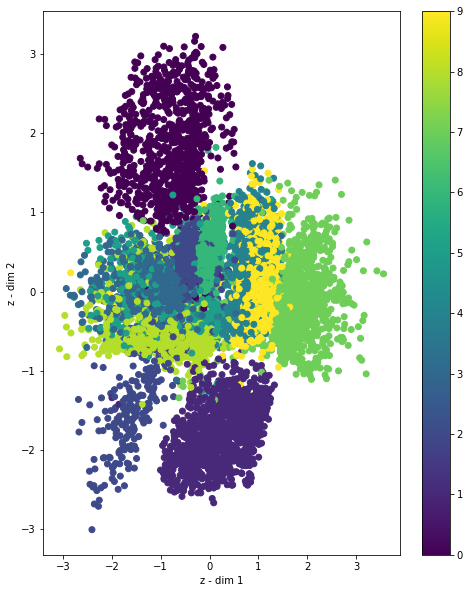

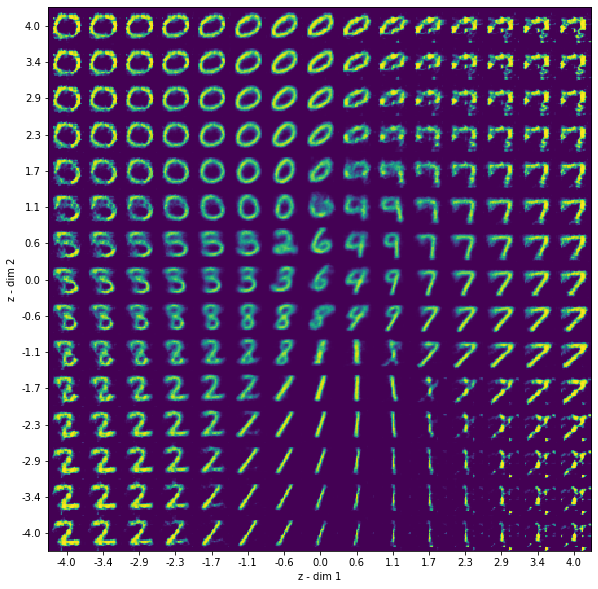

In [21]:
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                   j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    #matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    #so reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    #show image
    plt.imshow(figure)
    plt.show()

#plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

The scatterplot shows that, around (0,0), the latent space is fairly continuous as well as complete. However, moving outwards from this point, holes are seen, particularly near the edges.

These issues are seen in the actual sampling too. Where samples are blurred, this indicates issues with continuity.

This can be improved on by using deep convolutional generative adversarial network (DCGAN).

### DCGAN

Here, the architecture of the model will be modified to have deeper and wider convolutional layers.

#### DCGAN-like encoder

In [25]:
i = Input(shape=input_shape, name='encoder_input')
cx = Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(20, activation='relu')(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

In [26]:
#get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [27]:
#reparameterisation trick to ensure correct gradient
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [28]:
#instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 1024) 26624       encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 14, 14, 1024) 4096        conv2d_10[0][0]                  
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 200704)       0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

#### DCGAN-like decoder

In [29]:
d_i = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x = BatchNormalization()(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx = Conv2DTranspose(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
o = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [30]:
#instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 200704)            602112    
_________________________________________________________________
batch_normalization_22 (Batc (None, 200704)            802816    
_________________________________________________________________
reshape_3 (Reshape)          (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 128)       3276928   
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         1153

#### DCGAN-like VAE as a whole

In [31]:
#instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4044984   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         4683521   
Total params: 8,728,505
Trainable params: 8,324,753
Non-trainable params: 403,752
_________________________________________________________________


#### Compile and train

In [32]:
#compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [34]:
#train autoencoder
vae.fit(input_train, input_train, epochs = 10, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 973s 20ms/step - loss: 276.8048 - val_loss: 222.4401
Epoch 2/10
48000/48000 [==============================] - 994s 21ms/step - loss: 176.6027 - val_loss: 176.2303
Epoch 3/10
48000/48000 [==============================] - 974s 20ms/step - loss: 168.6255 - val_loss: 164.9367
Epoch 4/10
48000/48000 [==============================] - 978s 20ms/step - loss: 163.3449 - val_loss: 159.4368
Epoch 5/10
48000/48000 [==============================] - 974s 20ms/step - loss: 160.4141 - val_loss: 159.6604
Epoch 6/10
48000/48000 [==============================] - 969s 20ms/step - loss: 158.8575 - val_loss: 156.6318
Epoch 7/10
48000/48000 [==============================] - 974s 20ms/step - loss: 157.7106 - val_loss: 159.0304
Epoch 8/10
48000/48000 [==============================] - 982s 20ms/step - loss: 156.8602 - val_loss: 156.9101
Epoch 9/10
48000/48000 [==============================] - 977s

#### Visualise results

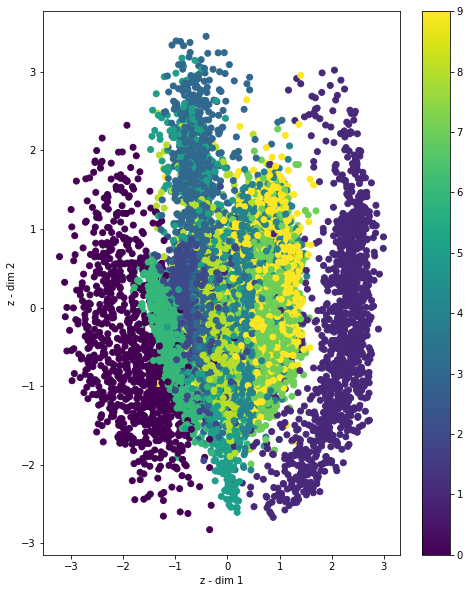

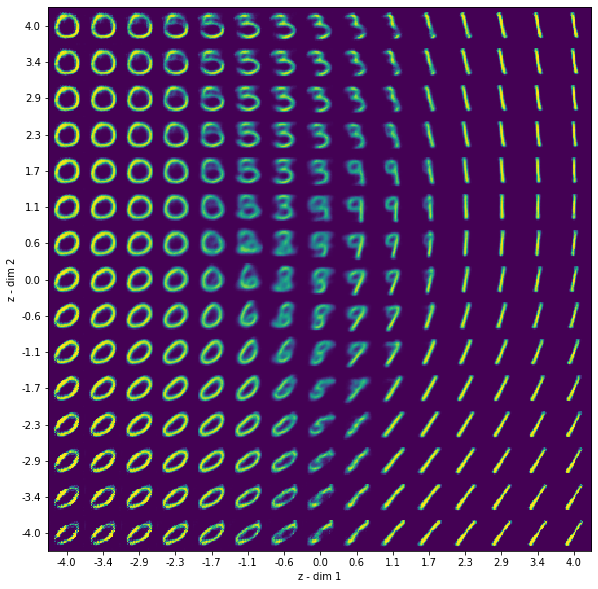

In [35]:
#plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

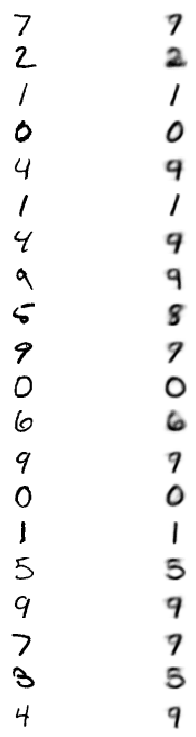

In [40]:
#visualise reconstructions for a sample of the test set
plt.ioff()
plt.figure(figsize=(5,20))
for i in range(20):
    plt.subplot(30, 2, 2*i+1)
    img = np.reshape(input_test[i], (img_width, img_height))
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')
    
    plt.subplot(30, 2, 2*i+2)
    encoder_input = np.expand_dims(input_test[i], axis=0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(input_test[0], (img_width, img_height))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (img_width, img_height)), cmap='gray_r')

## CIFAR VAE

The same process from above can be applied to the CIFAR dataset. The main changes are the image sizes and num_channels - as RGB is used, the value for num_channels is now 3.

In [87]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [88]:
img_width, img_height = x_train.shape[1], x_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 3 #as RGB

In [89]:
x_train.shape

(50000, 32, 32, 3)

In [90]:
#reshape data
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

#parse numbers as floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#normalise data
x_train = x_train / 255
x_test = x_test / 255

In [91]:
i = Input(shape=input_shape, name='encoder_input')
cx = Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
cx = Conv2D(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(i)
cx = BatchNormalization()(cx)
x = Flatten()(cx)
x = Dense(20, activation='relu')(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

In [92]:
#get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [93]:
#reparameterisation trick to ensure correct gradient
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [94]:
#instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 16, 16, 1024) 77824       encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 16, 16, 1024) 4096        conv2d_18[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 262144)       0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

In [95]:
d_i = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x = BatchNormalization()(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx = Conv2DTranspose(filters=1024, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=512, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
cx = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
cx = BatchNormalization()(cx)
o = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [96]:
#instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 262144)            786432    
_________________________________________________________________
batch_normalization_42 (Batc (None, 262144)            1048576   
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 32, 32, 128)       3276928   
_________________________________________________________________
batch_normalization_46 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         3459

In [97]:
#instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 5324984   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         5115907   
Total params: 10,440,891
Trainable params: 9,914,259
Non-trainable params: 526,632
_________________________________________________________________


In [98]:
#compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [99]:
#train autoencoder
vae.fit(x_train, x_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 988s 25ms/step - loss: 696.7271 - val_loss: 702.2512
Epoch 2/50
40000/40000 [==============================] - 993s 25ms/step - loss: 662.3895 - val_loss: 667.2631
Epoch 3/50
40000/40000 [==============================] - 955s 24ms/step - loss: 660.0657 - val_loss: 659.3521
Epoch 4/50
40000/40000 [==============================] - 951s 24ms/step - loss: 657.9709 - val_loss: 657.2972
Epoch 5/50
40000/40000 [==============================] - 950s 24ms/step - loss: 657.0235 - val_loss: 658.0493
Epoch 6/50
40000/40000 [==============================] - 950s 24ms/step - loss: 656.4920 - val_loss: 656.1526
Epoch 7/50
40000/40000 [==============================] - 950s 24ms/step - loss: 656.0550 - val_loss: 655.8743
Epoch 8/50
40000/40000 [==============================] - 959s 24ms/step - loss: 655.9799 - val_loss: 655.1459
Epoch 9/50
40000/40000 [==============================] - 943s

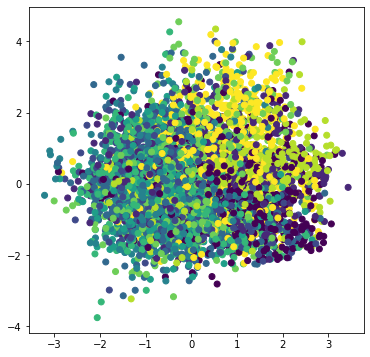

In [100]:
#reshape y_test for colours
y_test1 = [item for sublist in y_test for item in sublist]

m, s, t = encoder.predict(x_test)
plt.figure(figsize=(6,6))
plt.scatter(m[:,0], m[:,1], c=y_test1)

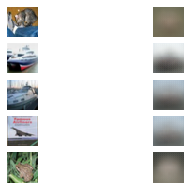

In [101]:
#visualise reconstructions for a sample of the test set
plt.ioff()
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(30, 4, 4*i+1)
    img = np.reshape(x_test[i], (img_width, img_height, num_channels))
    plt.axis('off')
    plt.imshow(img)
    
    plt.subplot(30, 4, 4*i+2)
    encoder_input = np.expand_dims(x_test[i], axis=0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(x_test[0], (img_width, img_height, num_channels))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (img_width, img_height, num_channels)))

This clearly has not performed particularly well. Substantially more training would be required and modifications ot the VAE.